# Libraries

In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.8 MB/s eta 0:00:00


In [169]:
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter

import re
import emoji

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [28]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')

In [96]:
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
train.head()

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


# EDA

In [ ]:
train.isna().sum()

,0
review,0
sentiment,0


No Na, great!

In [97]:
y_train = (train['sentiment'] == 'positive').astype(int)
y_test = (test['sentiment'] == 'positive').astype(int)

In [88]:
train['target'] = (train['sentiment'] == 'positive').astype(int)
test['target'] =

In [ ]:
train.head()

,review,sentiment,target
0,I caught this little gem totally by accident b...,positive,1
1,I can't believe that I let myself into this mo...,negative,0
2,*spoiler alert!* it just gets to me the nerve ...,negative,0
3,If there's one thing I've learnt from watching...,negative,0
4,"I remember when this was in theaters, reviews ...",negative,0


In [ ]:
train['target'].mean()

0.5

Balanced data, perfect!

In [ ]:
train.duplicated().sum()

272

In [5]:
train.drop_duplicates(inplace = True)

In [6]:
def stats(df, text_column):
  stat_df = pd.DataFrame()
  stat_df['length'] = df[text_column].apply(len)
  stat_df['word_count'] = df[text_column].apply(lambda x: len(x.split()))
  stat_df['sentence_count'] = df[text_column].apply(lambda x: len(str(x).split(".")))
  return stat_df

In [7]:
stat = stats(train, 'review')

In [8]:
def hist(df, column):
  df[column].hist(bins = 50)
  plt.title(column)
  plt.show()

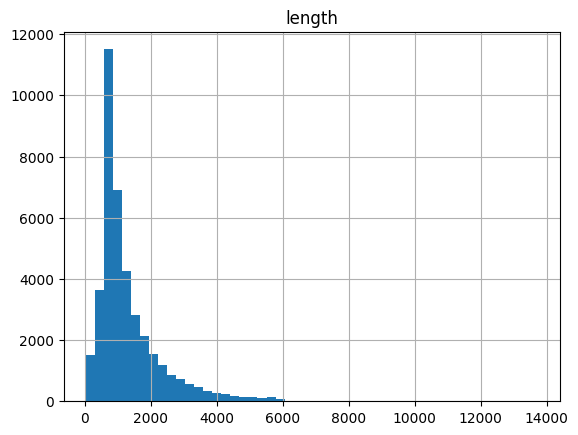

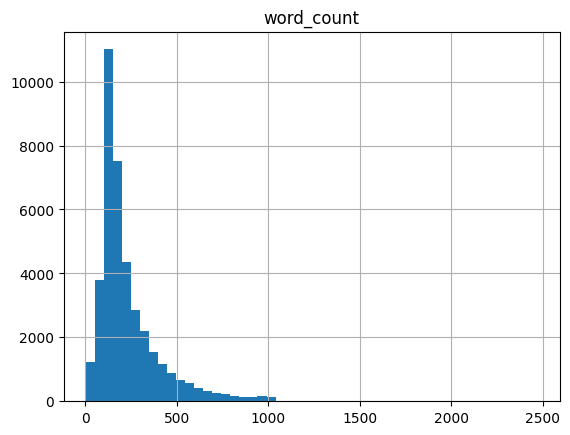

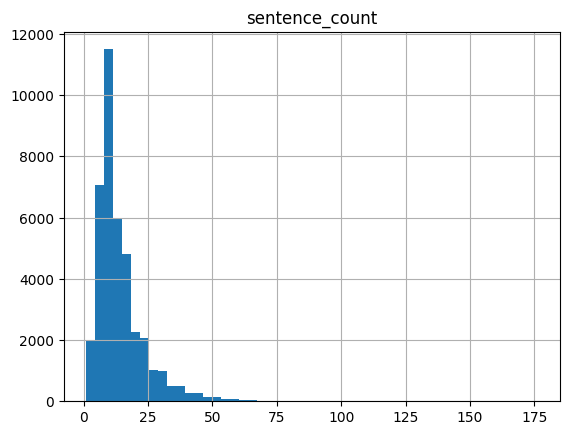

In [ ]:
for column in stat.columns:
  hist(stat, column)
  print()

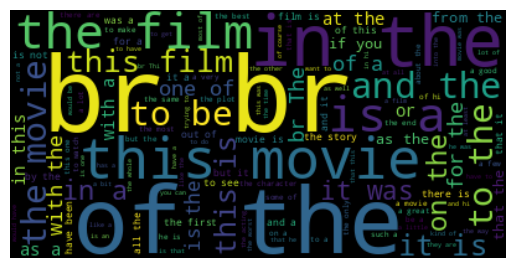

In [ ]:
text = ' '.join(train['review'].values)
wordcloud = WordCloud(stopwords='english').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

br is text break, so we should definitely clean. Also gramatically common words: the, and, etc.

In [79]:
def ngrams(text, n, color):
  vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=None, max_features=20)
  X = vectorizer.fit_transform(text.astype(str))

  ngrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)
  plt.figure(figsize = (6,4))
  ngrams.head(20).plot(kind = 'bar', colormap = color, title = f'{n}_grams')
  plt.show()

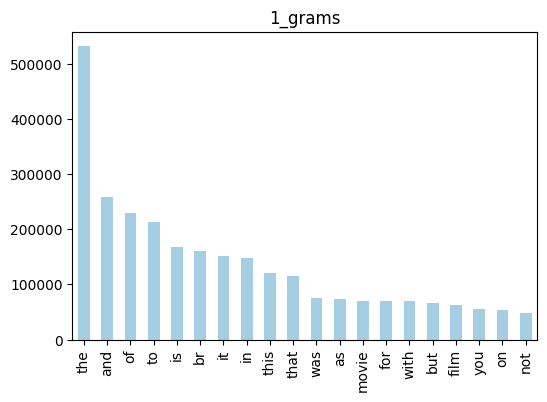

In [80]:
ngrams(train['review'], 1, 'Paired')

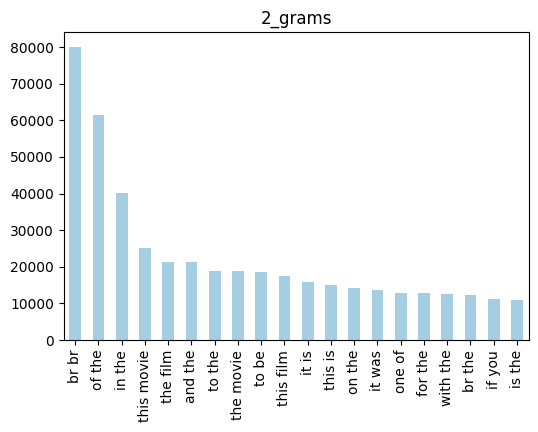

In [81]:
ngrams(train['review'], 2, 'Paired')

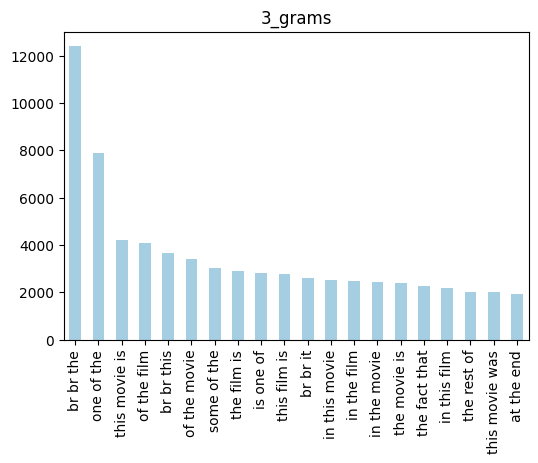

In [82]:
ngrams(train['review'], 3, 'Paired')

Review is full of unnecessary stop words, we should definetely filter them out.

In [ ]:
url_pattern = r"https?://\S+|www\.\S+"

train["review"].apply(lambda x: bool(re.search(url_pattern, x))).sum()

155

Just wanna know if there is any emoji

In [49]:
def extract_emojis(text):
    return "".join(c for c in text if c in emoji.EMOJI_DATA)

In [ ]:
emojis = train['review'].apply(extract_emojis)

In [ ]:
emojis[emojis !='']

,review
79,®
1078,®
6930,®
26141,©
34661,®


Nothing related to emotion, so it will be cleaned.

# Feature Engineering

In [15]:
def clean(text):

  text = text.lower()  # Lowercasing
  text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
  text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
  text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters & punctuation
  text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespaces

  return text

In [16]:
train['clean_review'] = train['review'].apply(clean)

In [21]:
def token(text):

  text = word_tokenize(text)

  return text

In [22]:
train['token'] = train['clean_review'].apply(token)

In [15]:
train['review'][0]

'I caught this little gem totally by accident back in 1980 or \'81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). Most were somewhat amusing but THIS came on and, within seconds, the audience was in hysterics! The biggest laugh came when they showed "Princess Laia" having huge cinnamon buns instead of hair on her head. She looks at the camera, gives a grim smile and nods. That made it even funnier! You gotta see "Chewabacca" played by what looks like a Muppet! It was extremely silly and stupid...but I couldn\'t stop laughing. Most of the dialogue was drowned out because of all the laughter. Also if you know "Star Wars" pretty well it\'s even funnier--they deliberately poke fun at some of the dialogue. This REALLY works with an audience! A definite 10!'

In [16]:
train['clean_review'][0]

'i caught this little gem totally by accident back in or i was at a revival theatre to see two old silly scifi movies the theatre was packed full and with no warning they showed a bunch of scifi short spoofs to get us in the mood most were somewhat amusing but this came on and within seconds the audience was in hysterics the biggest laugh came when they showed princess laia having huge cinnamon buns instead of hair on her head she looks at the camera gives a grim smile and nods that made it even funnier you gotta see chewabacca played by what looks like a muppet it was extremely silly and stupidbut i couldnt stop laughing most of the dialogue was drowned out because of all the laughter also if you know star wars pretty well its even funnierthey deliberately poke fun at some of the dialogue this really works with an audience a definite'

In [23]:
def stopword(text):

  stop_words = set(stopwords.words("english"))
  text = [word for word in text if word not in stop_words]

  return text


In [24]:
train['clean_token'] = train['token'].apply(stopword)

In [33]:
def join(text):
  text = ' '.join(text)
  return text

In [34]:
train['review1'] = train['clean_token'].apply(join)

In [35]:
train

,review,sentiment,clean_review,token,clean_token,review1
0,I caught this little gem totally by accident b...,positive,i caught this little gem totally by accident b...,"[i, caught, this, little, gem, totally, by, ac...","[caught, little, gem, totally, accident, back,...",caught little gem totally accident back reviva...
1,I can't believe that I let myself into this mo...,negative,i cant believe that i let myself into this mov...,"[i, cant, believe, that, i, let, myself, into,...","[cant, believe, let, movie, accomplish, favor,...",cant believe let movie accomplish favor friend...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert it just gets to me the nerve som...,"[spoiler, alert, it, just, gets, to, me, the, ...","[spoiler, alert, gets, nerve, people, remake, ...",spoiler alert gets nerve people remake use ter...
3,If there's one thing I've learnt from watching...,negative,if theres one thing ive learnt from watching g...,"[if, theres, one, thing, ive, learnt, from, wa...","[theres, one, thing, ive, learnt, watching, ge...",theres one thing ive learnt watching george ro...
4,"I remember when this was in theaters, reviews ...",negative,i remember when this was in theaters reviews s...,"[i, remember, when, this, was, in, theaters, r...","[remember, theaters, reviews, said, horrible, ...",remember theaters reviews said horrible well d...
...,...,...,...,...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,positive,its the s and a man named walt disney was on a...,"[its, the, s, and, a, man, named, walt, disney...","[man, named, walt, disney, mission, satisfy, f...",man named walt disney mission satisfy families...
39996,"The first (and only) time I saw ""Shades"" was d...",negative,the first and only time i saw shades was durin...,"[the, first, and, only, time, i, saw, shades, ...","[first, time, saw, shades, sneakpreview, hadnt...",first time saw shades sneakpreview hadnt even ...
39997,This was such a waste of time. Danger: If you ...,negative,this was such a waste of time danger if you wa...,"[this, was, such, a, waste, of, time, danger, ...","[waste, time, danger, watch, tempted, tear, dv...",waste time danger watch tempted tear dvd wall ...
39998,this is by far the most pathetic movie Indian ...,negative,this is by far the most pathetic movie indian ...,"[this, is, by, far, the, most, pathetic, movie...","[far, pathetic, movie, indian, cinema, cinema,...",far pathetic movie indian cinema cinema come w...


In [36]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

In [38]:
train["text_stemmed"] = train["review1"].apply(stem_words)

In [39]:
train['text_stemmed'][0]

'caught littl gem total accid back reviv theatr see two old silli scifi movi theatr pack full warn show bunch scifi short spoof get us mood somewhat amus came within second audienc hyster biggest laugh came show princess laia huge cinnamon bun instead hair head look camera give grim smile nod made even funnier got ta see chewabacca play look like muppet extrem silli stupidbut couldnt stop laugh dialogu drown laughter also know star war pretti well even funnierthey deliber poke fun dialogu realli work audienc definit'

In [40]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [42]:
train["text_lemma"] = train["review1"].apply(lemmatize_words)

In [43]:
train['text_lemma'][0]

'caught little gem totally accident back revival theatre see two old silly scifi movie theatre packed full warning showed bunch scifi short spoof get u mood somewhat amusing came within second audience hysteric biggest laugh came showed princess laia huge cinnamon bun instead hair head look camera give grim smile nod made even funnier got ta see chewabacca played look like muppet extremely silly stupidbut couldnt stop laughing dialogue drowned laughter also know star war pretty well even funnierthey deliberately poke fun dialogue really work audience definite'

In [45]:
train['review1'][0]

'caught little gem totally accident back revival theatre see two old silly scifi movies theatre packed full warning showed bunch scifi short spoofs get us mood somewhat amusing came within seconds audience hysterics biggest laugh came showed princess laia huge cinnamon buns instead hair head looks camera gives grim smile nods made even funnier got ta see chewabacca played looks like muppet extremely silly stupidbut couldnt stop laughing dialogue drowned laughter also know star wars pretty well even funnierthey deliberately poke fun dialogue really works audience definite'

To be honest I don't understand without modeling how they should be compared, therefore I will try final model on both of them and will choose in terms of accuracy. As I know lemmatization is better in terms of errors.

In [58]:
positive = train[train['sentiment']=='positive'][['text_lemma', 'sentiment']]
negative = train[train['sentiment']=='negative'][['text_lemma', 'sentiment']]

In [68]:
def common_words(text, color):
  plt.figure(figsize=(6,4))
  pd.Series(' '.join(text).split()).value_counts().head(20).plot(kind = 'bar', colormap = color)
  plt.show()

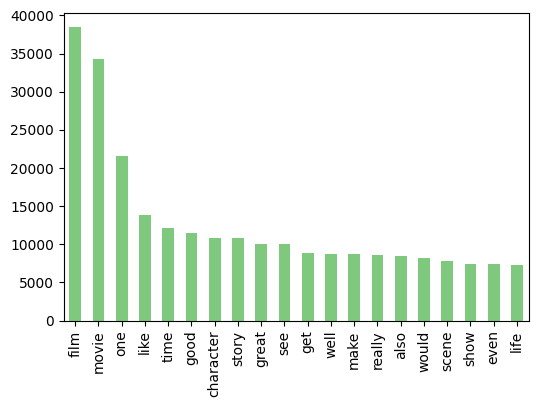

In [69]:
common_words(positive['text_lemma'], 'Accent')

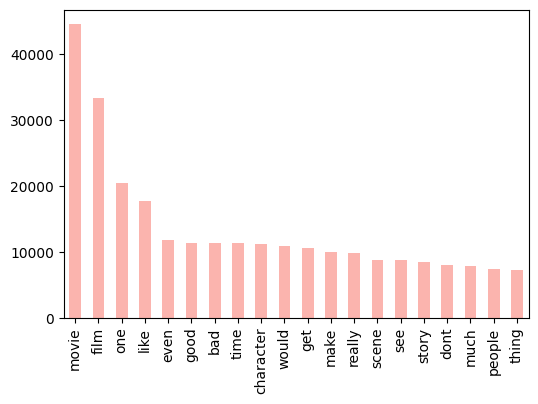

In [70]:
common_words(negative['text_lemma'], 'Pastel1')

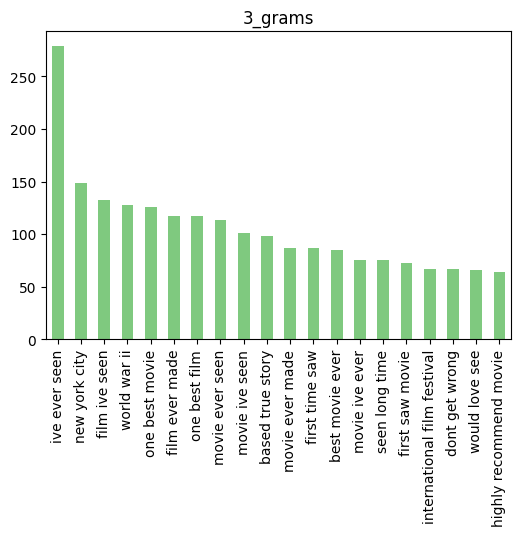

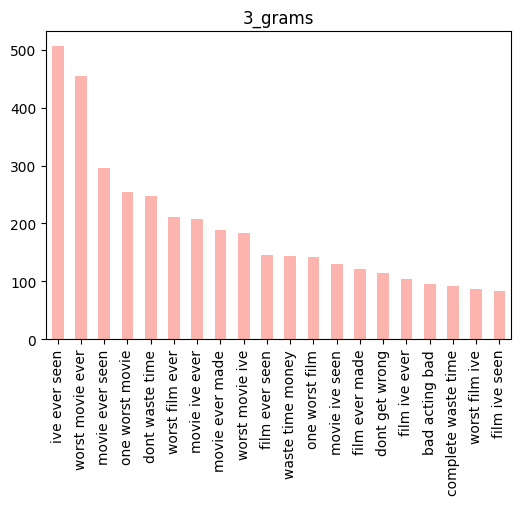

In [84]:
ngrams(positive['text_lemma'], 3, 'Accent')
print()
ngrams(negative['text_lemma'], 3, 'Pastel1')

I really loved the method of TF-IDF theoretically and I will try it. But I'm just thinking about dropping common words or not, just to make it computationally less expensive.

In [87]:
train

,review,sentiment,clean_review,token,clean_token,review1,text_stemmed,text_lemma
0,I caught this little gem totally by accident b...,positive,i caught this little gem totally by accident b...,"[i, caught, this, little, gem, totally, by, ac...","[caught, little, gem, totally, accident, back,...",caught little gem totally accident back reviva...,caught littl gem total accid back reviv theatr...,caught little gem totally accident back reviva...
1,I can't believe that I let myself into this mo...,negative,i cant believe that i let myself into this mov...,"[i, cant, believe, that, i, let, myself, into,...","[cant, believe, let, movie, accomplish, favor,...",cant believe let movie accomplish favor friend...,cant believ let movi accomplish favor friend a...,cant believe let movie accomplish favor friend...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert it just gets to me the nerve som...,"[spoiler, alert, it, just, gets, to, me, the, ...","[spoiler, alert, gets, nerve, people, remake, ...",spoiler alert gets nerve people remake use ter...,spoiler alert get nerv peopl remak use term lo...,spoiler alert get nerve people remake use term...
3,If there's one thing I've learnt from watching...,negative,if theres one thing ive learnt from watching g...,"[if, theres, one, thing, ive, learnt, from, wa...","[theres, one, thing, ive, learnt, watching, ge...",theres one thing ive learnt watching george ro...,there one thing ive learnt watch georg romero ...,there one thing ive learnt watching george rom...
4,"I remember when this was in theaters, reviews ...",negative,i remember when this was in theaters reviews s...,"[i, remember, when, this, was, in, theaters, r...","[remember, theaters, reviews, said, horrible, ...",remember theaters reviews said horrible well d...,rememb theater review said horribl well didnt ...,remember theater review said horrible well did...
...,...,...,...,...,...,...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,positive,its the s and a man named walt disney was on a...,"[its, the, s, and, a, man, named, walt, disney...","[man, named, walt, disney, mission, satisfy, f...",man named walt disney mission satisfy families...,man name walt disney mission satisfi famili ch...,man named walt disney mission satisfy family c...
39996,"The first (and only) time I saw ""Shades"" was d...",negative,the first and only time i saw shades was durin...,"[the, first, and, only, time, i, saw, shades, ...","[first, time, saw, shades, sneakpreview, hadnt...",first time saw shades sneakpreview hadnt even ...,first time saw shade sneakpreview hadnt even p...,first time saw shade sneakpreview hadnt even p...
39997,This was such a waste of time. Danger: If you ...,negative,this was such a waste of time danger if you wa...,"[this, was, such, a, waste, of, time, danger, ...","[waste, time, danger, watch, tempted, tear, dv...",waste time danger watch tempted tear dvd wall ...,wast time danger watch tempt tear dvd wall hea...,waste time danger watch tempted tear dvd wall ...
39998,this is by far the most pathetic movie Indian ...,negative,this is by far the most pathetic movie indian ...,"[this, is, by, far, the, most, pathetic, movie...","[far, pathetic, movie, indian, cinema, cinema,...",far pathetic movie indian cinema cinema come w...,far pathet movi indian cinema cinema come with...,far pathetic movie indian cinema cinema come w...


In [130]:
X_train = train['text_lemma']
#X_train = train['text_stemmed']
X_test = test['sentiment']

In [131]:
def clean_review(text):
  text = text.lower()  # Lowercasing
  text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
  text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
  text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters & punctuation
  text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespaces

  text = word_tokenize(text) # Tokenization

  stop_words = set(stopwords.words("english")) # Removing stop words
  text = [word for word in text if word not in stop_words]
  text = ' '.join(text)
  #text = " ".join([stemmer.stem(word) for word in text.split()])  # Stemming
  text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemma

  return text

I have commented those sections, because I later compared the results of lemma and stem and there was not much difference (accuracy of ~89% in both case), but since lemma is generally considered as better method I will leave it. I did not include the results, since it will not have sophisticated look with too many metrics.

In [132]:
X_test = test['review'].apply(clean_review)

# Vectorization

## TF-IDF

In [128]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:

'''
    # Save metrics to file
    with open(save_path, "w") as f:
        f.write("Classification Report:\n")
        f.write(class_report + "\n")
        f.write("=" * 50 + "\n")
        f.write(f"Accuracy  : {accuracy:.4f}\n")
        f.write(f"Precision : {precision:.4f}\n")
        f.write(f"Recall    : {recall:.4f}\n")
        f.write(f"F1-score  : {f1:.4f}\n")
        if auc_roc is not None:
            f.write(f"AUC-ROC   : {auc_roc:.4f}\n")
        f.write("=" * 50 + "\n")

'''

## N-gram

In [161]:
ngram_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=5000)  # Unigrams + Bigrams
X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

# Model

In [156]:
def cm(y_true, y_pred):
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
  disp.plot(cmap = 'Greens')
  plt.show()

In [173]:
def metrics(y_true, y_pred, y_prob=None, save_path="metrics.txt"):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    auc_roc = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    print("=" * 50)
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-score  : {f1:.4f}")
    if y_prob != None:
      print(f"AUC-ROC   : {auc_roc:.4f}")
    print("=" * 50)


## Logistic Regression

In [158]:
# Fitting Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression()

Test Results
Accuracy  : 0.8842
Precision : 0.8764
Recall    : 0.8946
F1-score  : 0.8854
AUC-ROC   : 0.9537


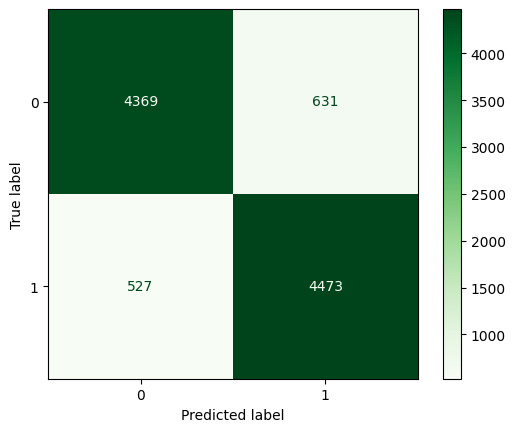

In [159]:
y_pred = log_reg.predict(X_test_tfidf)
y_prob = log_reg.predict_proba(X_test_tfidf)
print('Test Results')
metrics(y_test, y_pred, y_prob[:, 1])
cm(y_test, y_pred)

Train Results
Accuracy  : 0.9074
Precision : 0.9003
Recall    : 0.9169
F1-score  : 0.9085
AUC-ROC   : 0.9685


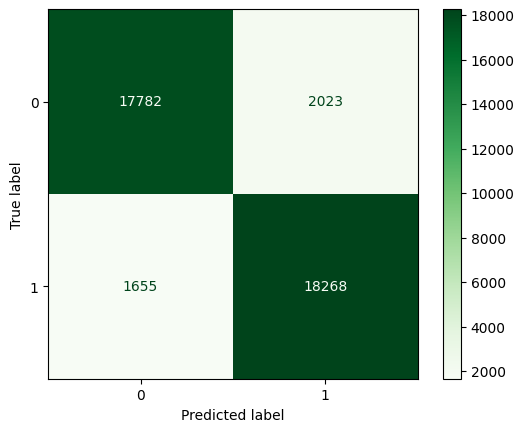

In [160]:
y_pred = log_reg.predict(X_train_tfidf)
y_prob = log_reg.predict_proba(X_train_tfidf)
print('Train Results')
metrics(y_train, y_pred, y_prob[:, 1])
cm(y_train, y_pred)

To choose vectorization method, I will compare it with the same baseline model. And try other algorithms only after this.

In [162]:
log_reg = LogisticRegression()
log_reg.fit(X_train_ngram, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Test Results
Accuracy  : 0.8725
Precision : 0.8708
Recall    : 0.8748
F1-score  : 0.8728
AUC-ROC   : 0.9417


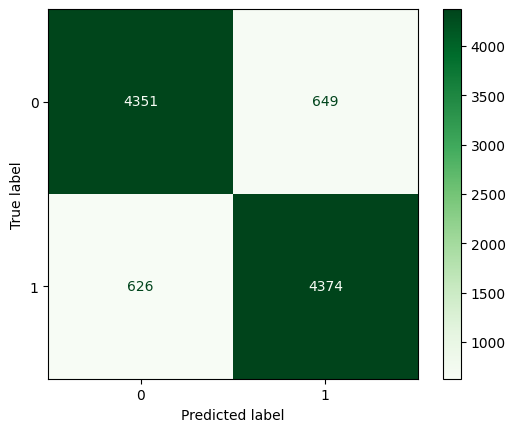

In [163]:
y_pred = log_reg.predict(X_test_ngram)
y_prob = log_reg.predict_proba(X_test_ngram)
print('Test Results')
metrics(y_test, y_pred, y_prob[:, 1])
cm(y_test, y_pred)

Train Results
Accuracy  : 0.9359
Precision : 0.9329
Recall    : 0.9397
F1-score  : 0.9363
AUC-ROC   : 0.9833


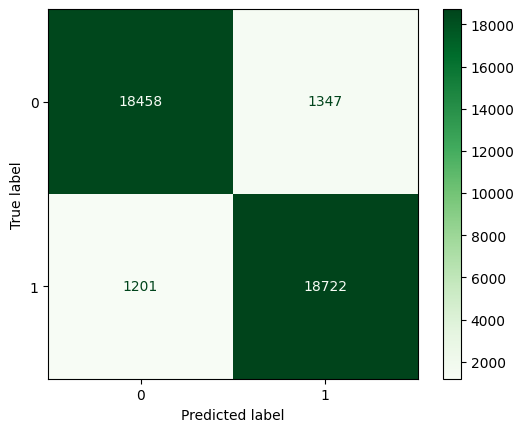

In [164]:
y_pred = log_reg.predict(X_train_ngram)
y_prob = log_reg.predict_proba(X_train_ngram)
print('Train Results')
metrics(y_train, y_pred, y_prob[:, 1])
cm(y_train, y_pred)

Interesting result here, as it seems in case of n-grams. The pattern of train data is preserved well but can not generalize on unseen data, since there is much discrepancy between train and test results. Hence TF-IDF is better, as it could have been predicted theoretically.

## Random Forest

In [166]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

Test Results - Random Forest
Accuracy  : 0.8483
Precision : 0.8550
Recall    : 0.8388
F1-score  : 0.8468
AUC-ROC   : 0.9256


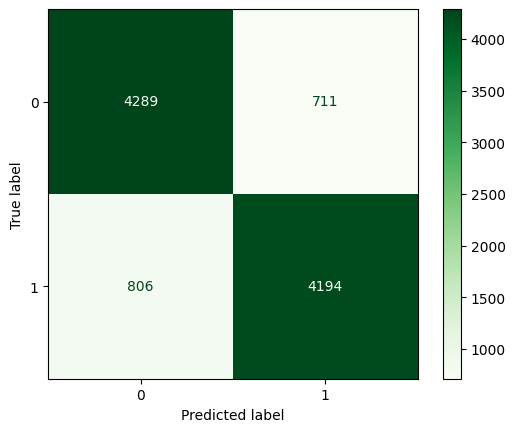

In [167]:
y_pred = rf_model.predict(X_test_tfidf)
y_prob = rf_model.predict_proba(X_test_tfidf)
print('Test Results - Random Forest')
metrics(y_test, y_pred, y_prob[:, 1])
cm(y_test, y_pred)

Train Results - Random Forest
Accuracy  : 1.0000
Precision : 1.0000
Recall    : 1.0000
F1-score  : 1.0000
AUC-ROC   : 1.0000


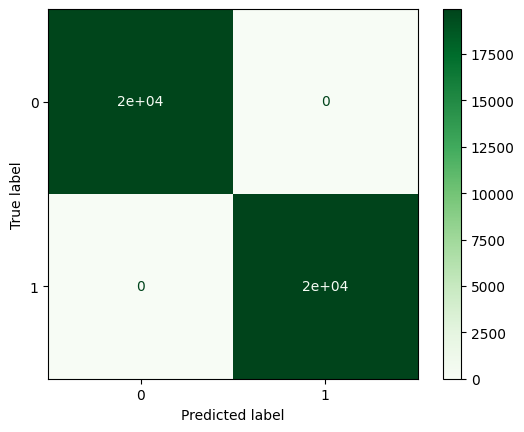

In [168]:
y_pred = rf_model.predict(X_train_tfidf)
y_prob = rf_model.predict_proba(X_train_tfidf)
print('Train Results - Random Forest')
metrics(y_train, y_pred, y_prob[:, 1])
cm(y_train, y_pred)

## SVM

In [170]:
svm_model = SVC(kernel='linear', random_state=42)  # Linear kernel is often a good choice for text data
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=42)

In [172]:
y_pred = svm_model.predict(X_test_tfidf)
#y_prob = svm_model.predict_proba(X_test_tfidf)


Test Results - SVM Model
Accuracy  : 0.8812
Precision : 0.8749
Recall    : 0.8896
F1-score  : 0.8822


TypeError: unsupported format string passed to NoneType.__format__

Test Results - SVM Model
Accuracy  : 0.8812
Precision : 0.8749
Recall    : 0.8896
F1-score  : 0.8822


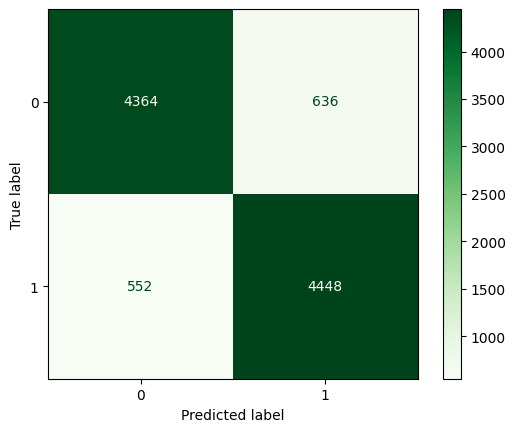

In [174]:
print('Test Results - SVM Model')
metrics(y_test, y_pred)
cm(y_test, y_pred)